## CSB: Data Science Internship Assignment
<p> Predictive modelling for a 'Rare' event in the customer experience journey. <br>  All resulting Precision-recall Curves in accompanying folder and some intermediate results in accompanying excel sheet.<br>
    <b> Data and Problem Description</b><br></p>

* The data provided is time-series for various accounts along with a label that signifies whether an intervention was required for the account. ~60 features are provided that I'm assuming are metrics that have something to do with the account/customer interaction with certain features. Possible that as interaction goes down below a threshold. the customer/account is at risk of leaving. So the intervention might be required to get the interaction back up ? 

* <b> Imbalanced Binary Classification Problem - Evaluation Metrics (Precision Recall, F1 Score)</b><br>
 Since the Positive Label is extremely scarce (~1%, minority class), Accuracy can be misleading. Precision, Recall are more suitable metrics. I'll be using the F1-score (their harmonic mean) and the Precision-Recall curve to evaluate my models. <br>
 
* <b> Data already Cleaned, Pre-processed </b>, was mentioned on stream that the data doesn't need to be normalised/standardised and all columns seem to be intact, in suitable data types. Had to scale it for the ANN.

<b>Approach</b>
1. Simple Naive Method - Feature Selection and Classification Models. Not sequence models, don't directly exploit time-series.
 * <b> Dealing with the Imbalance - Weighted cost functions </b>
 Weighing the models by using inverse frequency of the classes. Undersampling the data resulted in lower performance.
 * <b> Prioritizing higher Recall </b> since the event is rare and needs intervention, it'll be better to proritize  recall rate even if a lower precision results in a few false positives, as we don't want to miss the actual accounts that need intervention.
 * <b> Feature Selection using Multivariate EDA and Random-Forest on entire feature set</b>
 *  Split the training data into train and validation by account ID to avoid leak, 62 % in train, 38 % in validation, gives around .94% positive class in both.
 * <b> Simple Classification Models like Logistic Regression, Random Forest Classifier, XGBoost Classifier </b> used and tuned on the selected features from training and validation data before final P-R curve on Test set. Tried a simple ANN but results in low training performance (possibly not enough data, loss not going down, difficult to tune), SVCs were extremely slow to train.
 * <b> Tried a Voting classifer </b> ensemble, doesn't improve performance. Better tuning of classifiers needed.
 
2. Time-Series based approach - Performed some exploratory analysis of the overall time series and by accounts. No modelling done.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from itertools import combinations
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.utils import np_utils

pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None
CPU_CORES = 8

Using TensorFlow backend.
/home/desktop-anand/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/desktop-anand/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/desktop-anand/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/desktop-anand/.local/lib/python3.6/sit

#### Helper Functions 
A few helper functions that are used to split the data properly by account ID, check if any overlapping accounts exist between two sets and to plot the precision-recall curves for a list of models.

In [2]:
def overlap_sanity_check(x_train, x_test):
    '''Checks if unique accounts IDs overlap in the sets.
    '''
    for i in x_train.index.unique():
        if i in x_test.index.unique():
            print('Overlap')
            break

In [3]:
def train_test_split_acc(df, test_size = 0.38):
    ''' Splits the DF (includes labels) into Train, validation sets by AccountID.
    Default .38 selected as it keeps the distribution of the labels similar in both sets.
    '''
    df.sort_index(inplace=True)
    split_acc = df.index.unique()[math.ceil((len(df.index.unique())* test_size))]
    x_train = df.loc[df.index > split_acc]
    x_test = df.loc[df.index <= split_acc]
    y_train = x_train['Label']
    y_test = x_test['Label']
    x_train.drop(['Label'], axis = 1, inplace = True)
    x_test.drop(['Label'], axis = 1, inplace = True)
    print(f'Split of Labels in train set \n{y_train.value_counts()/len(y_train)}')
    temp_train = x_train.reset_index().account_id
    temp_test = x_test.reset_index().account_id
    print(f'Number of Accounts in Train {len(temp_train.unique())} \n')
    print(f'Split of Labels in test set \n{y_test.value_counts()/len(y_test)}')
    print(f'Number of Accounts in Train {len(temp_test.unique())}\n')
    overlap_sanity_check(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [4]:
def plot_pr_cuves(clf_list, x, y, title):
    ''' Takes in a list of initialised and fitted classifier instances
    and the DF and labels used for validation.
    save: String for Saving Graph in /Curves
    '''
    fig,ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    for clf in clf_list:
          plot_precision_recall_curve(clf, x.values, y, ax = ax)
    plt.savefig(f'Curves/{title}.jpg')
    plt.title(title)
    plt.show()

## A. Baseline Models
1. Baseline Models uisng All Features and balanced weights, plotting Preision-Recall curve on the validation set . Using Random Forest's feature importance for lead on Important Features.
2. So, <b>Baseline Featureset - all features.</b>

In [5]:
# Data indexed by account ID.
train = pd.read_csv('Train_Set.csv', index_col=0)
test = pd.read_csv('Test_Set.csv', index_col=0)
# Data Balance - # 2690 Accounts in train and 713 in test (This shouldn't influence my modelling methodology.)
train.Label.value_counts()/len(train)

0    0.990619
1    0.009381
Name: Label, dtype: float64

In [6]:
test.Label.value_counts()/len(test)

0    0.990648
1    0.009352
Name: Label, dtype: float64

In [7]:
train.head(2)

,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
account_id,,,,,,,,,,,,,,,,,,,,,
100559.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
# Data balance on split train, validation sets. - This gives 1666 accounts in train and 1024 accounts in validation.
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

Split of Labels in train set 
0    0.990644
1    0.009356
Name: Label, dtype: float64
Number of Accounts in Train 1666 

Split of Labels in test set 
0    0.990585
1    0.009415
Name: Label, dtype: float64
Number of Accounts in Train 1024



In [9]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)
# Saving baseline feature set 
baseline_features = x_train.columns.to_list()

In [10]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [12]:
# Initialising Classifiers with gridsearch optimised parameters, log-reg wont converge with all features
# f-1 score on train dataset. Scores when optimising in excel sheet.

clf_log = LogisticRegression(class_weight={0:1, 1:class_weight}, max_iter = 300, n_jobs= -1)
clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6, class_weight={0:1, 1:class_weight}, n_jobs= -1)
xgb_clf = XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')
# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train), y_train)
clf_rf.fit(np.array(x_train), y_train)
xgb_clf.fit(np.array(x_train), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train)))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train)))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

[0]	validation_0-aucpr:0.30426
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.31879
[2]	validation_0-aucpr:0.32037
[3]	validation_0-aucpr:0.31283
[4]	validation_0-aucpr:0.32315
[5]	validation_0-aucpr:0.32630
[6]	validation_0-aucpr:0.31831
[7]	validation_0-aucpr:0.33701
[8]	validation_0-aucpr:0.33582
[9]	validation_0-aucpr:0.33559
[10]	validation_0-aucpr:0.33754
[11]	validation_0-aucpr:0.34919
[12]	validation_0-aucpr:0.34939
[13]	validation_0-aucpr:0.35000
[14]	validation_0-aucpr:0.35346
[15]	validation_0-aucpr:0.35390
[16]	validation_0-aucpr:0.35301
[17]	validation_0-aucpr:0.35345
[18]	validation_0-aucpr:0.35321
[19]	validation_0-aucpr:0.35288
[20]	validation_0-aucpr:0.35740
[21]	validation_0-aucpr:0.35785
[22]	validation_0-aucpr:0.36788
[23]	validation_0-aucpr:0.36803
[24]	validation_0-aucpr:0.36833
[25]	validation_0-aucpr:0.36699
[26]	validation_0-aucpr:0.36108
[27]	validation_0-aucpr:0.35612
[28]	validation_0-aucpr:0.35919
[29]	validation_0

#### Validation Set Metrics
Both recall and accuracy are low,will try feature selection and optimising the hyperparameters classifiers.

In [13]:
y_pred_log = clf_log.predict(np.array(x_test))
y_pred_rf = clf_rf.predict(np.array(x_test))
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     47134
           1       0.16      0.45      0.24       448

    accuracy                           0.97     47582
   macro avg       0.58      0.71      0.61     47582
weighted avg       0.99      0.97      0.98     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.25      0.43      0.31       448

    accuracy                           0.98     47582
   macro avg       0.62      0.71      0.65     47582
weighted avg       0.99      0.98      0.98     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.22      0.54      0.31       448

    accuracy                           0.98     47582
   macro avg       0.61      0.76      0.65     47582
weighted avg  

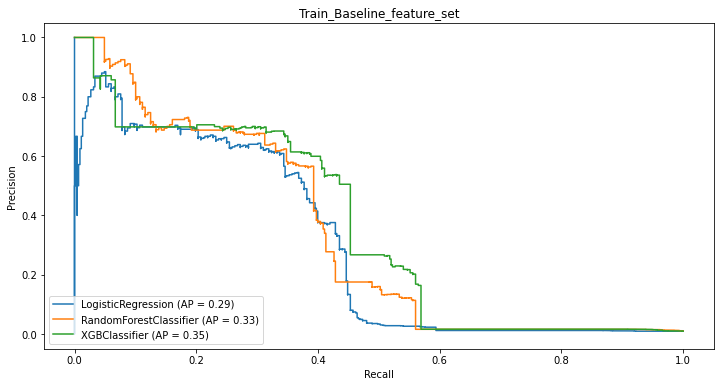

In [14]:
plot_pr_cuves(clf_list, x_test, y_test,title = 'Train_Baseline_feature_set')

#### Important Features from Random Forest -  (10 most important features)

In [14]:
## Get feature importance from RF
feat_imp = pd.DataFrame(index=x_train.columns , data = clf_rf.feature_importances_, columns=['Feature_Importance'])
feat_imp.sort_values(by = 'Feature_Importance', axis = 0, ascending=False, inplace = True)
imp_features = feat_imp.index.to_list()[:10]
feat_imp[:10]

,Feature_Importance
feature15,0.276513
feature37,0.117287
feature12,0.090862
feature16,0.069542
feature18,0.046947
feature47,0.044973
feature22,0.042251
feature19,0.041626
feature21,0.041556
feature53,0.041259


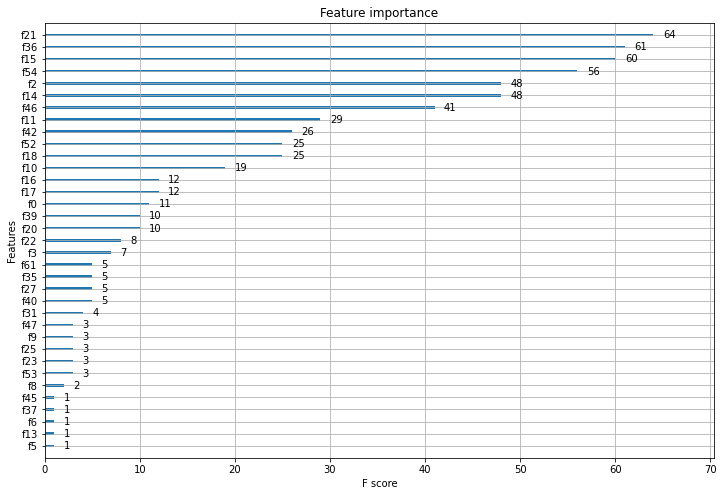

In [16]:
# feature number +1 
plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [14, 8]
plt.show()

## Recursive Feature Selection 
From Random Forest Classifier and XGBoost Classifer, it appears there are maybe 7-8 important Features. Using RFE to check which are the most useful features. RFE is a greedy technique that uses the .coef_ or .feature_importance attribute of classifiers to reursively build and test models while removing the least useful features at each stage. 

In [17]:
feat_sel = RFE(XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,n_estimators = 100,objective='binary:logistic',
                             learning_rate = .2, eval_metric = 'aucpr', n_jobs = CPU_CORES),
               n_features_to_select=8, step=8, verbose=1)
feat_sel.fit(np.array(x_train), y_train)

Fitting estimator with 62 features.
Fitting estimator with 54 features.
Fitting estimator with 46 features.
Fitting estimator with 38 features.
Fitting estimator with 30 features.
Fitting estimator with 22 features.
Fitting estimator with 14 features.


RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, eval_metric='aucpr',
                            gamma=None, gpu_id=None, importance_type='gain',
                            interaction_constraints=None, learning_rate=0.2,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=8, num_parallel_tree=None, random_state=None,
                            reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=105.88535031847134, subsample=None,
                            tree_method=None, validate_parameters=None,
                            verbosity=None),
    n_features_to_select=8, step=8, verbose=1)

In [18]:
# Selected features
pd.DataFrame(data = feat_sel.ranking_, index = x_train.columns).sort_values(by = 0, ascending = True).head(10)

,0
feature12,1
feature37,1
feature40,1
feature21,1
feature6,1
feature54,1
feature16,1
feature15,1
feature47,2
feature19,2


In [19]:
rfe_feats = ['feature12', 'feature37', 'feature40','feature21','feature6', 'feature54', 'feature16', 'feature15']
xgb_clf.fit(np.array(x_train[rfe_feats]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[rfe_feats]), y_test)],
             verbose=True)

clf_log.fit(np.array(x_train[rfe_feats]), y_train)
clf_rf.fit(np.array(x_train[rfe_feats]), y_train)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[rfe_feats])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[rfe_feats])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[rfe_feats])))}')

[0]	validation_0-aucpr:0.32388
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.32376
[2]	validation_0-aucpr:0.32598
[3]	validation_0-aucpr:0.32625
[4]	validation_0-aucpr:0.30895
[5]	validation_0-aucpr:0.32687
[6]	validation_0-aucpr:0.32665
[7]	validation_0-aucpr:0.33513
[8]	validation_0-aucpr:0.33498
[9]	validation_0-aucpr:0.34048
[10]	validation_0-aucpr:0.34269
[11]	validation_0-aucpr:0.34439
[12]	validation_0-aucpr:0.34402
[13]	validation_0-aucpr:0.34508
[14]	validation_0-aucpr:0.34519
[15]	validation_0-aucpr:0.34449
[16]	validation_0-aucpr:0.34469
[17]	validation_0-aucpr:0.34505
[18]	validation_0-aucpr:0.34432
[19]	validation_0-aucpr:0.36877
[20]	validation_0-aucpr:0.36908
[21]	validation_0-aucpr:0.36889
[22]	validation_0-aucpr:0.36908
[23]	validation_0-aucpr:0.37409
[24]	validation_0-aucpr:0.37433
[25]	validation_0-aucpr:0.37099
[26]	validation_0-aucpr:0.37047
[27]	validation_0-aucpr:0.37606
[28]	validation_0-aucpr:0.38023
[29]	validation_0

In [20]:
y_pred_xgb = xgb_clf.predict(np.array(x_test[rfe_feats]))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.40      0.48      0.44       448

    accuracy                           0.99     47582
   macro avg       0.70      0.74      0.72     47582
weighted avg       0.99      0.99      0.99     47582



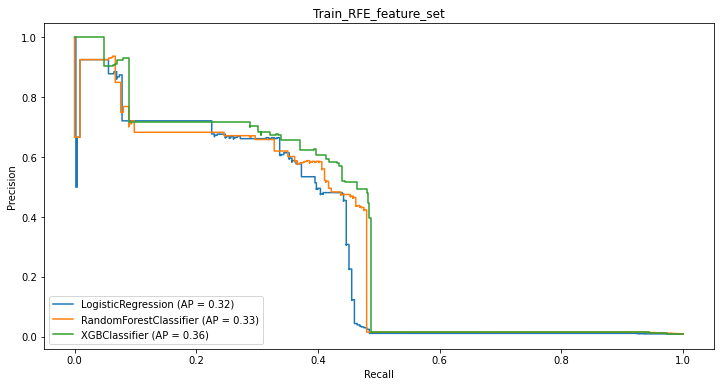

In [21]:
plot_pr_cuves(clf_list, x_test[rfe_feats], y_test,title = 'Train_RFE_feature_set')

## Multivariate EDA, Data Interaction and Manual Feature Selection

### Perason's Correlation Between Features 
1. Finding and plotting the features with highest absolute correlations between them, along with the positive labels in yellow. 
2. The most correlated features don't seem to have much discriminating power, most likely adding noise,  can be ignored.

In [36]:
## Getting the highest absolute correlations between features. Get pair of features, find correlations for each pair,
# store in list along with feature names

temp = train.drop(['Label', 'week_start_date'] , axis = 1).copy()
temp_corr = temp.corr()

corr_list = []
pair_feat = []
# Reduced complexity from two nested for loops uisng itertools combinations.
for i, item in enumerate(list(combinations(temp.columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]
#corr_array[104:124]

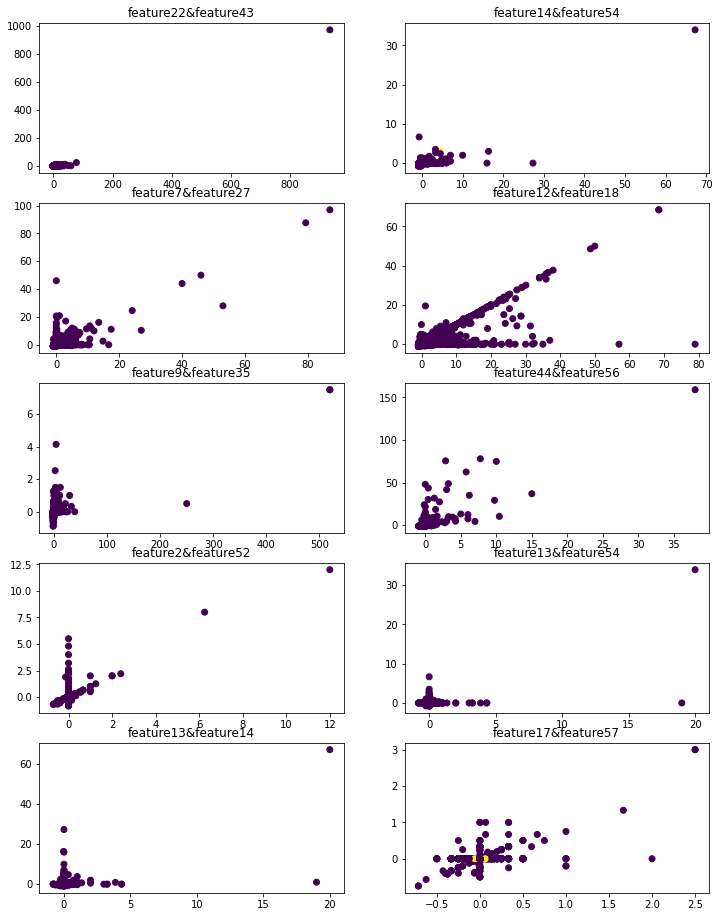

In [15]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(12)
for i, item in enumerate(corr_array[104:114]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.set_title(item[0] + '&' + item[1])

## Pearson's correlation of features with Label 
1. Although the pearson's correlation for the continuous variables and categorical target is not strictly meaningful, in practise it can be useful. <br> 
2. The skew can also affect the correlation, checked later with the majority class undersampled. Tried to model with undersampled data but resulted in worse performance that weighted cost.
3. Features 15, 16, 37 seem to be highly correlated with the label.<br>
<b>Feature Set 1 (3 features with highest Correlation with label)</b>

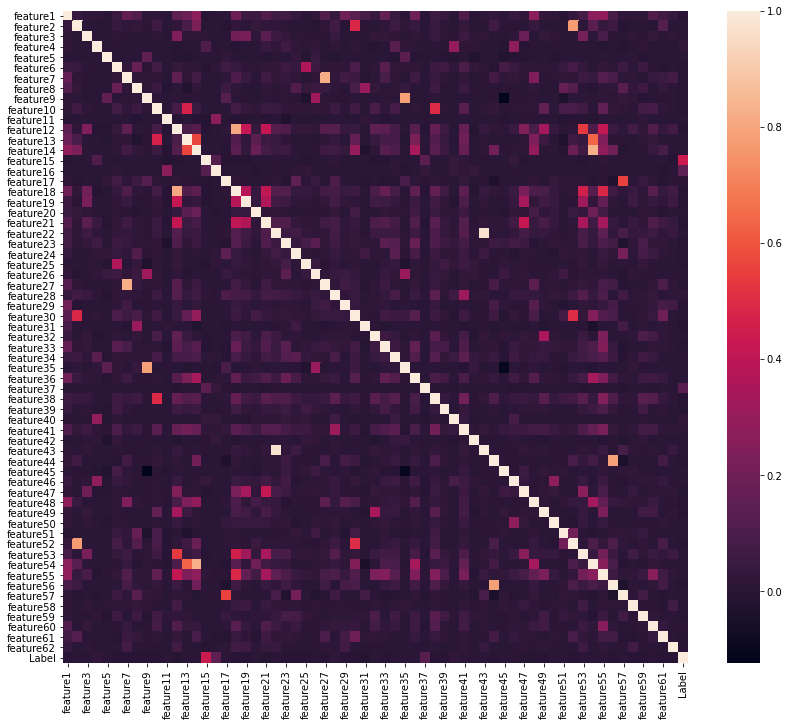

In [24]:
temp = train.copy()
#temp.drop(['Label'], axis =1, inplace = True)
plt.figure(figsize=(14,12))
sns.heatmap(temp.corr(method='pearson'))
plt.show()

### Randomly Undersampling Majority Class and then checking correlation with label
1. This method is not robust as we're throwing away a lot of data. We can see that as values for certain features  in the sample are just 0, shows up as no correlation with any other features below.
2. The features that appear to be correlated with the labels for this sample are the ones selected from the multivariate EDA below. Those assumptions seems to have been correct.
3. Modelled using undersampled data, lower performance than using all data, graph saved in Curves folder, suffixed undersamplped.

In [16]:
temp = train.copy()
# shuffling the train set before 
temp = temp.sample(frac = 1, random_state = 15)
# getting the same number of samples for majority class, 1076
intervene = temp.loc[temp['Label'] == 1]
no_intervene = temp.loc[temp['Label'] == 0].iloc[:1076]
new_df = pd.concat([intervene, no_intervene ])
# shuffling this new df
new_df = new_df.sample(frac=1)
new_df.Label.value_counts()

1    1076
0    1076
Name: Label, dtype: int64

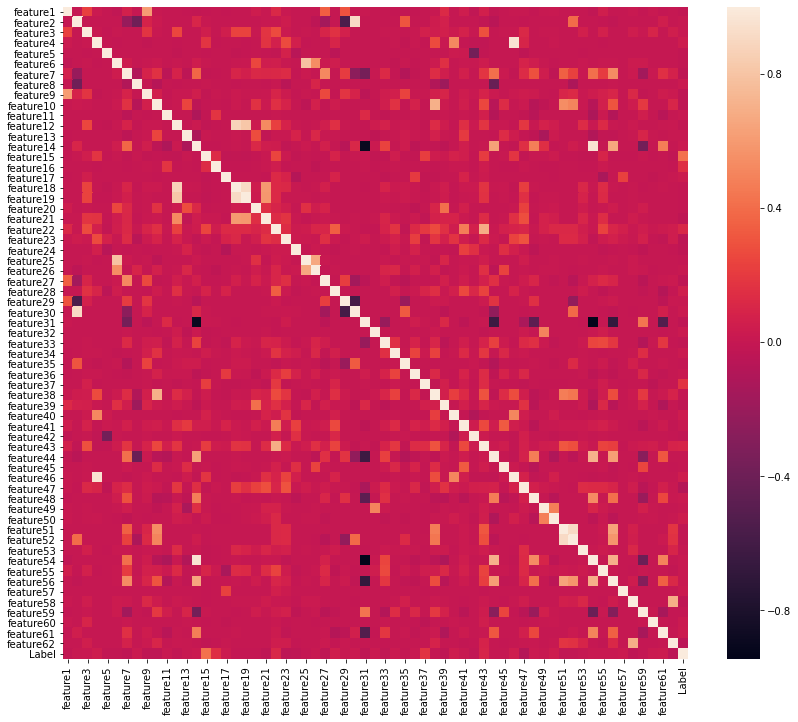

In [17]:
# Now correlations for this balanced subsample. 
plt.figure(figsize=(14,12))
sns.heatmap(new_df.corr(method = 'pearson'))
plt.show()

### Data Interaction of features correlated with label.
1. The yellow points denote the instances where an intervention was required or a label of 1.
2. There is definitely interesting interaction between these features, there is clear distinction between the postive classes in the graphs on the first column.
3. Comparing these plots with the interaction of multiple accounts with features from the livestream, it appears to be that these features cross each other just around the min threshold.
4. These features don't seem to be highly correlated.
2. Interestingly, the useful features are the ones whose interaction have a distinct cross like interaction. The labels turning to 1 somewhat depends on the points being on the outside of the interaction of the points. Can Use this info to find more such interactions(Total 1890 combinations, have to narrow it down).

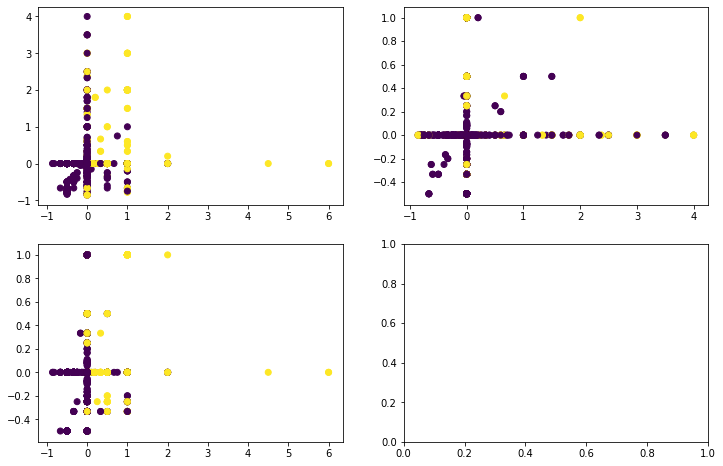

In [27]:
# Correlation of 0.125
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0,0].scatter(x = train['feature15'].values, y = train['feature16'].values, c = train.Label.values)
# Correlation of 0.0310
ax[0,1].scatter(x = train['feature16'].values, y = train['feature37'].values, c = train.Label.values)
# Correlation of 0.141
ax[1,0].scatter(x = train['feature15'].values, y = train['feature37'].values, c = train.Label.values)
plt.show()

![](multiple_accounts_single_features.png)

## B. Models using only the features most correlated with the label
1. Similar recall to previous model, much improved precision, the curve is also much more stable across the board.

In [34]:
feature_set_1 = ['feature15', 'feature16', 'feature37']

In [23]:
clf_log.fit(np.array(x_train[feature_set_1]), y_train)
clf_rf.fit(np.array(x_train[feature_set_1]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_1]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_1]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_1])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_1])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_1])))}')

[0]	validation_0-aucpr:0.31975
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.32058
[2]	validation_0-aucpr:0.32062
[3]	validation_0-aucpr:0.32080
[4]	validation_0-aucpr:0.32079
[5]	validation_0-aucpr:0.32079
[6]	validation_0-aucpr:0.32079
[7]	validation_0-aucpr:0.32884
[8]	validation_0-aucpr:0.32885
[9]	validation_0-aucpr:0.33386
[10]	validation_0-aucpr:0.33395
[11]	validation_0-aucpr:0.33386
[12]	validation_0-aucpr:0.33389
[13]	validation_0-aucpr:0.33381
[14]	validation_0-aucpr:0.33382
[15]	validation_0-aucpr:0.33490
[16]	validation_0-aucpr:0.33520
[17]	validation_0-aucpr:0.33541
[18]	validation_0-aucpr:0.35528
[19]	validation_0-aucpr:0.35400
[20]	validation_0-aucpr:0.35738
[21]	validation_0-aucpr:0.35700
[22]	validation_0-aucpr:0.35740
[23]	validation_0-aucpr:0.35757
[24]	validation_0-aucpr:0.35535
[25]	validation_0-aucpr:0.35696
[26]	validation_0-aucpr:0.35688
[27]	validation_0-aucpr:0.35763
[28]	validation_0-aucpr:0.35737
[29]	validation_0

In [24]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_1]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_1]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_1]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47134
           1       0.46      0.45      0.45       448

    accuracy                           0.99     47582
   macro avg       0.73      0.72      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.41      0.49      0.45       448

    accuracy                           0.99     47582
   macro avg       0.70      0.74      0.72     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.39      0.49      0.43       448

    accuracy                           0.99     47582
   macro avg       0.69      0.74      0.71     47582
weighted avg  

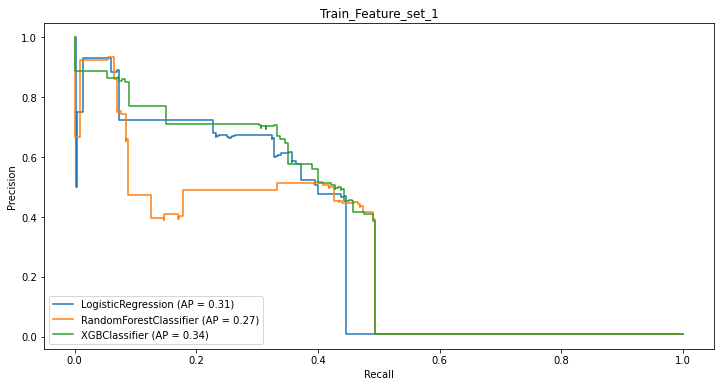

In [25]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Train_Feature_set_1')

### Plotting Important features from baseline Random Forest 
1. Interactions of other features shows similar behaviour to the features selected so far, this interaction of the data is seems important.
2. Creating Feature set 2 by combining a few promising features from these interactions and featureset1. 
3. <b>Featureset 2 (7 features). </b> Modelling.
4. Recall increased slightly.

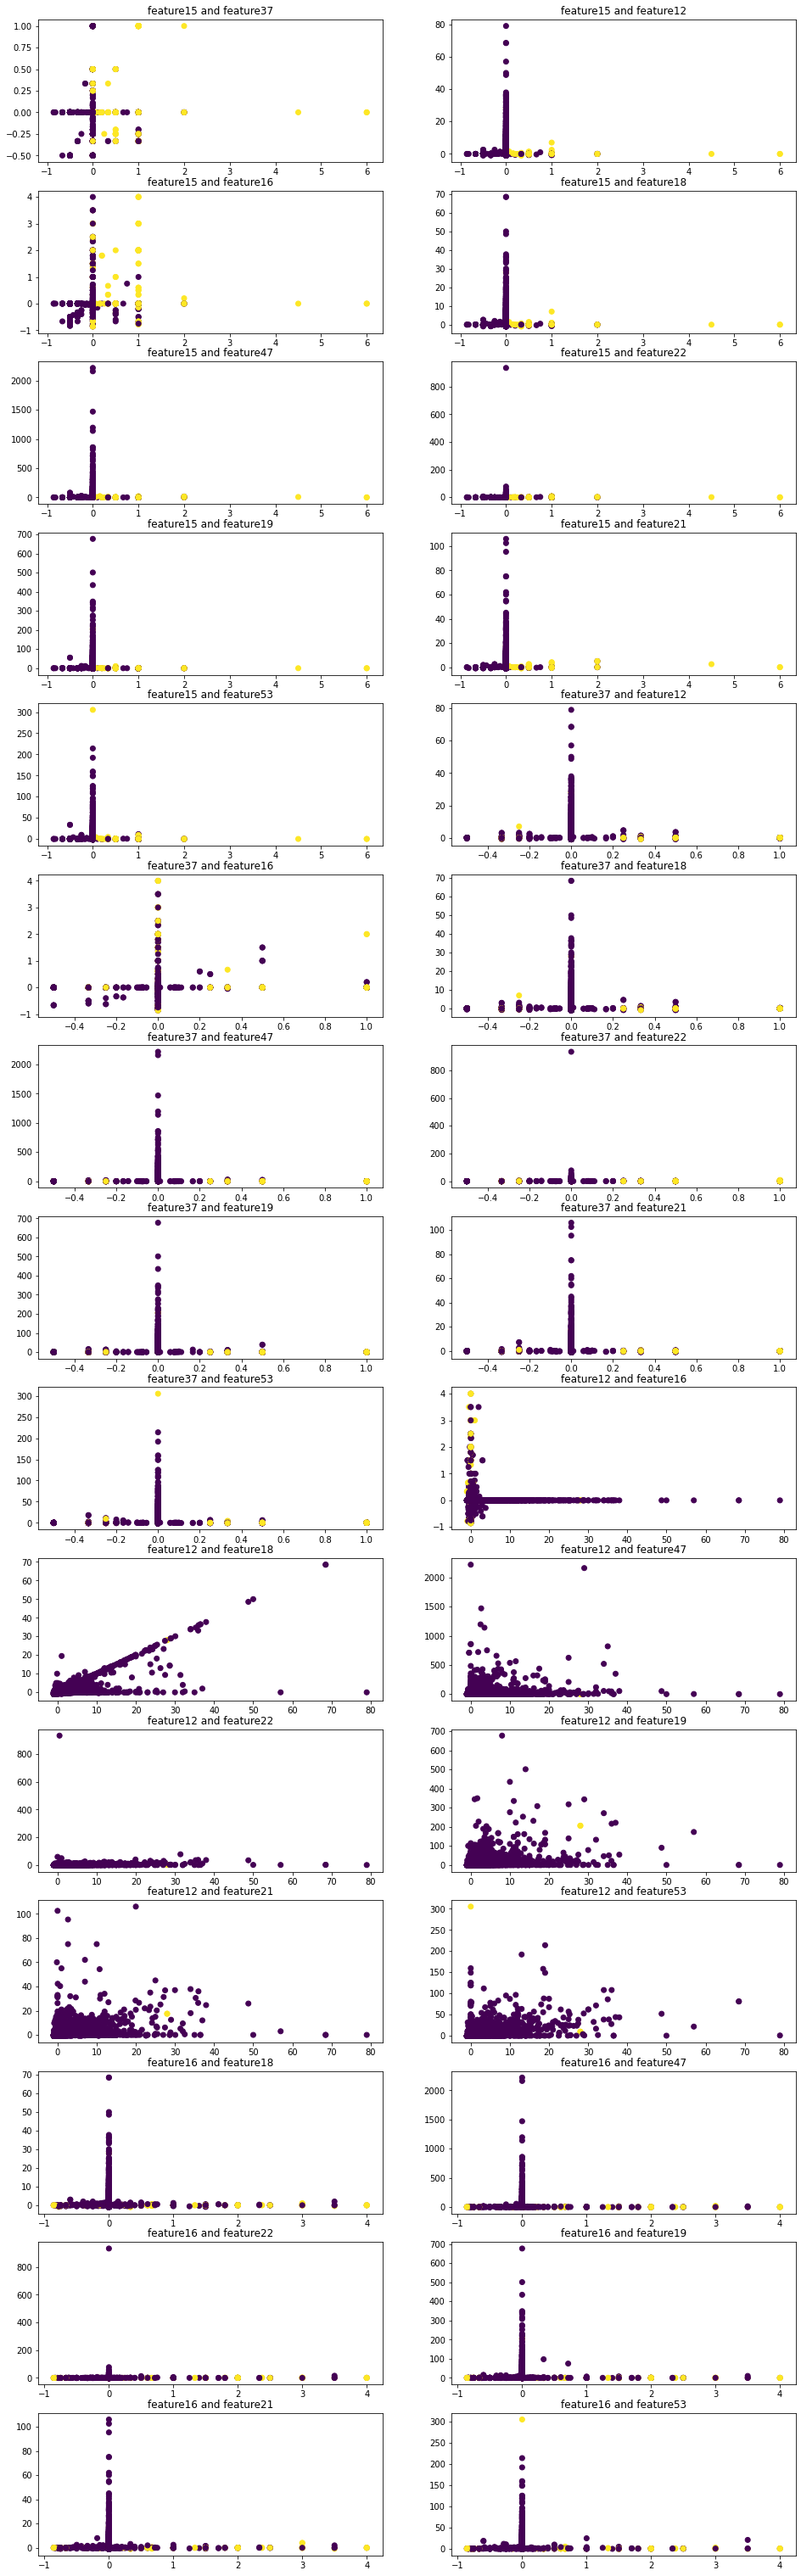

In [26]:
combinations_imp = list(combinations(imp_features, 2))
fig = plt.figure(figsize=(16, 55))
for i, item in enumerate(combinations_imp[:30]):
    ax = fig.add_subplot(15, 2, i+1)
    ax.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.title.set_text(f'{item[0]} and {item[1]}')
    
plt.show()

In [27]:
feature_set_2 = ['feature15', 'feature16', 'feature37','feature55',
                 'feature12', 'feature18', 'feature47']

clf_log.fit(np.array(x_train[feature_set_2]), y_train)
clf_rf.fit(np.array(x_train[feature_set_2]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_2]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_2]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_2])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_2])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_2])))}')

[0]	validation_0-aucpr:0.31828
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.33359
[2]	validation_0-aucpr:0.32990
[3]	validation_0-aucpr:0.34240
[4]	validation_0-aucpr:0.34654
[5]	validation_0-aucpr:0.33721
[6]	validation_0-aucpr:0.34594
[7]	validation_0-aucpr:0.35606
[8]	validation_0-aucpr:0.35849
[9]	validation_0-aucpr:0.35900
[10]	validation_0-aucpr:0.35990
[11]	validation_0-aucpr:0.36563
[12]	validation_0-aucpr:0.36542
[13]	validation_0-aucpr:0.36610
[14]	validation_0-aucpr:0.36545
[15]	validation_0-aucpr:0.36351
[16]	validation_0-aucpr:0.36391
[17]	validation_0-aucpr:0.36449
[18]	validation_0-aucpr:0.36505
Stopping. Best iteration:
[13]	validation_0-aucpr:0.36610

Logistic Regression - 0.5141471301535975
Random Forest - 0.35568235853542557
XGBoost - 0.3462929475587704


In [28]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_2]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_2]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_2]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.38      0.45      0.41       448

    accuracy                           0.99     47582
   macro avg       0.69      0.72      0.70     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.23      0.54      0.32       448

    accuracy                           0.98     47582
   macro avg       0.61      0.76      0.65     47582
weighted avg       0.99      0.98      0.98     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.21      0.56      0.31       448

    accuracy                           0.98     47582
   macro avg       0.60      0.77      0.65     47582
weighted avg  

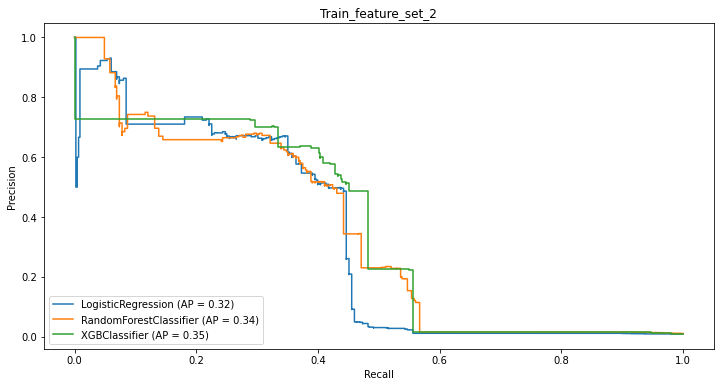

In [29]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Train_feature_set_2')

### C. Features with non-zero value and the largest counts of corresponding positive examples.
1. These features could have good discriminating power.
3. Featureset_3 (6 of the features with the largest count of positive examples), modelling.
3. Worse performance compared to featureset 2, the interaction of these features shows that they're going along similar lines, without the cross interaction seen before. Just goes about near the threshold ?
4. Trying to model by combining the two feature sets.

In [46]:
for item in train.columns:
    try:
        print(item, train.loc[train[item]!= 0].Label.value_counts()[1])
    except KeyError:
        pass

week_start_date 1076
feature1 18
feature3 215
feature4 9
feature6 2
feature7 8
feature9 8
feature10 8
feature11 36
feature12 83
feature14 4
feature15 406
feature16 105
feature17 10
feature18 75
feature19 66
feature21 70
feature22 299
feature23 40
feature24 5
feature26 5
feature27 4
feature28 47
feature31 2
feature32 9
feature33 5
feature34 23
feature36 17
feature37 209
feature38 13
feature39 10
feature40 10
feature41 61
feature43 262
feature44 4
feature45 1
feature46 15
feature47 99
feature48 6
feature49 7
feature50 8
feature53 129
feature54 4
feature55 273
feature56 4
feature57 1
feature58 12
feature59 2
feature60 10
feature61 2
feature62 24
Label 1076


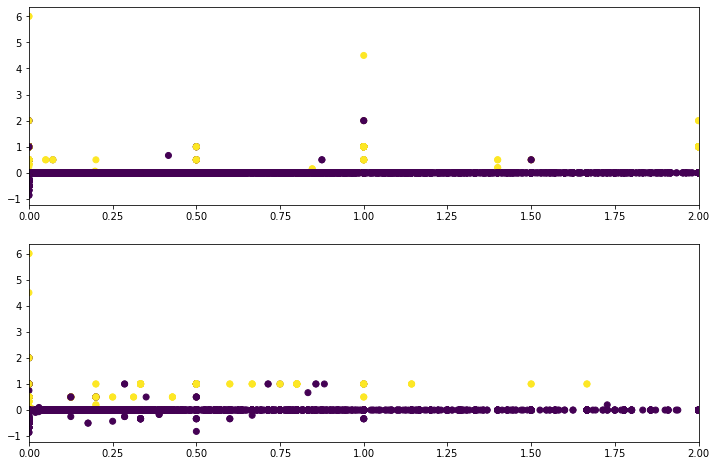

In [74]:
# try checking with 43, 3, 37 
fig, ax = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0].set_xlim(0,2)
ax[0].scatter(x = train['feature22'].values, y = train['feature15'].values, c = train.Label.values)
ax[1].set_xlim(0,2)
ax[1].scatter(x = train['feature55'].values, y = train['feature15'].values, c = train.Label.values)
plt.show()

In [30]:
feature_set_3 = ['feature15', 'feature22', 'feature55', 'feature43', 'feature3', 'feature37']
clf_log.fit(np.array(x_train[feature_set_3]), y_train)
clf_rf.fit(np.array(x_train[feature_set_3]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_3]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_3]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_3])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_3])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_3])))}')

[0]	validation_0-aucpr:0.31378
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.31378
[2]	validation_0-aucpr:0.31581
[3]	validation_0-aucpr:0.31861
[4]	validation_0-aucpr:0.31812
[5]	validation_0-aucpr:0.31804
[6]	validation_0-aucpr:0.31829
[7]	validation_0-aucpr:0.31725
[8]	validation_0-aucpr:0.32111
[9]	validation_0-aucpr:0.32104
[10]	validation_0-aucpr:0.32245
[11]	validation_0-aucpr:0.32312
[12]	validation_0-aucpr:0.32908
[13]	validation_0-aucpr:0.32373
[14]	validation_0-aucpr:0.32968
[15]	validation_0-aucpr:0.33116
[16]	validation_0-aucpr:0.32767
[17]	validation_0-aucpr:0.32930
[18]	validation_0-aucpr:0.33007
[19]	validation_0-aucpr:0.33626
[20]	validation_0-aucpr:0.33767
[21]	validation_0-aucpr:0.35586
[22]	validation_0-aucpr:0.35184
[23]	validation_0-aucpr:0.35147
[24]	validation_0-aucpr:0.34316
[25]	validation_0-aucpr:0.34183
[26]	validation_0-aucpr:0.34857
Stopping. Best iteration:
[21]	validation_0-aucpr:0.35586

Logistic Regression - 

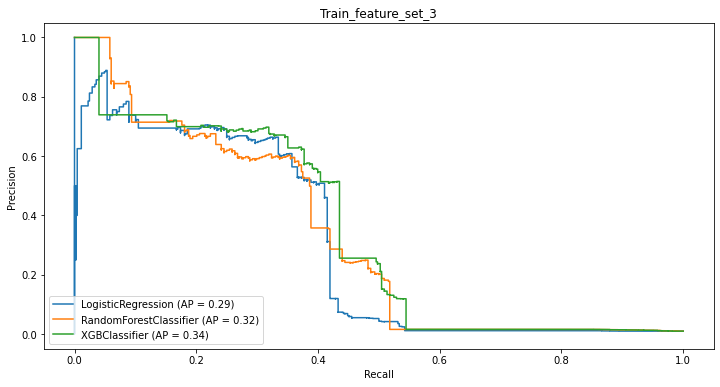

In [31]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Train_feature_set_3')

## D. Combining Features Selected till now
1. Featureset 4, 13 selected features.
2. Also Adding a voting classifier ensemble classifier.
3. Similar performance to feature_set_2, slighlty higher precision in upper range of recall.

In [16]:
feature_set_4  = ['feature15','feature37','feature55','feature47','feature18','feature12',
                 'feature19','feature21','feature43','feature16','feature53','feature3','feature22']

In [37]:
vote_clf = VotingClassifier([('log_reg', clf_log), ('rf_clf', clf_rf), ('xgb_clf', xgb_clf)]
                            , voting='soft', n_jobs=-1)
clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]

clf_log.fit(np.array(x_train[feature_set_4]), y_train)
clf_rf.fit(np.array(x_train[feature_set_4]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_4]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_4]), y_test)],
             verbose=True)
vote_clf.fit(np.array(x_train[feature_set_4]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_4])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_4])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_4])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[feature_set_4])))}')

[0]	validation_0-aucpr:0.31701
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.33332
[2]	validation_0-aucpr:0.32570
[3]	validation_0-aucpr:0.33636
[4]	validation_0-aucpr:0.33826
[5]	validation_0-aucpr:0.33331
[6]	validation_0-aucpr:0.34122
[7]	validation_0-aucpr:0.35216
[8]	validation_0-aucpr:0.35246
[9]	validation_0-aucpr:0.33984
[10]	validation_0-aucpr:0.34449
[11]	validation_0-aucpr:0.36234
[12]	validation_0-aucpr:0.36199
[13]	validation_0-aucpr:0.36332
[14]	validation_0-aucpr:0.36046
[15]	validation_0-aucpr:0.36207
[16]	validation_0-aucpr:0.36232
[17]	validation_0-aucpr:0.36283
[18]	validation_0-aucpr:0.36149
Stopping. Best iteration:
[13]	validation_0-aucpr:0.36332

Logistic Regression - 0.39261538461538464
Random Forest - 0.4608233731739708
XGBoost - 0.3549396513187304
VotingClassifier - 0.4601487778958555


In [20]:
y_pred = clf_log.predict(np.array(x_test[feature_set_4]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_4]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_4]))
y_pred_vclf = vote_clf.predict(np.array(x_test[feature_set_4]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.3032600454890068
0.2774352651048089
0.2929782082324455
0.3517915309446254


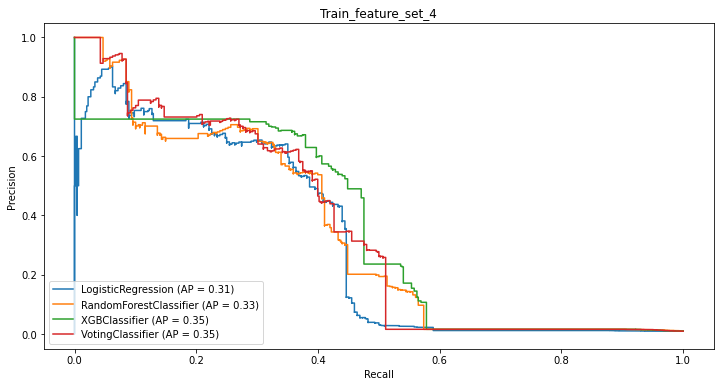

In [38]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Train_feature_set_4')

# Final Precision-Recall Curves on provided test set Using Naive Approach
1. Training the models on entire training data.
2. Predicting for test data, only using labels for the evaluation.
3. XGBoost with all the features still appears to slighlty outperform the models when trained with featureset4, still that's a reduction of the used features from 62 to 13. Clearly these features are important for the classification.
4. Hyperparameter optimization next, other techniques, feature selection done for the most part.

In [12]:
# Change the featureset before and fit on new featureset before plotting curve.
featureset = baseline_features

In [13]:
x_train = train[featureset]
y_train = train['Label']
x_test = test[featureset]
y_test = test['Label']

In [18]:
clf_log.fit(np.array(x_train[featureset]), y_train)
clf_rf.fit(np.array(x_train[featureset]), y_train)
xgb_clf.fit(np.array(x_train[featureset]), y_train)
# Set according to featureset and early stopping, letting model overfit slightly
xgb_clf.n_estimators = 300
xgb_clf.learning_rate = 0.5

vote_clf.fit(np.array(x_train[featureset]), y_train)

clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]
#clf_list = [clf_log, xgb_clf]


print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[featureset])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[featureset])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[featureset])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[featureset])))}')

Logistic Regression - 0.4624175824175824
Random Forest - 0.5201096892138939
XGBoost - 0.4906411788132218
VotingClassifier - 0.5414414414414415


In [20]:
y_pred = clf_log.predict(np.array(x_test[featureset]))
y_pred_rf = clf_rf.predict(np.array(x_test[featureset]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[featureset]))
y_pred_vclf = vote_clf.predict(np.array(x_test[featureset]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.4382207578253706
0.5093378607809848
0.46020260492040516
0.5297113752122241


In [74]:
# Before Plotting please, make sure correct featureset selected.

In [ ]:
# Randomly Undersampled data and baseline features 

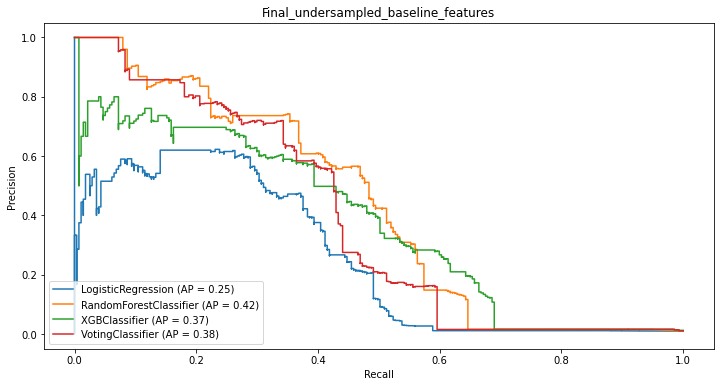

In [43]:
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_undersampled_baseline_features')

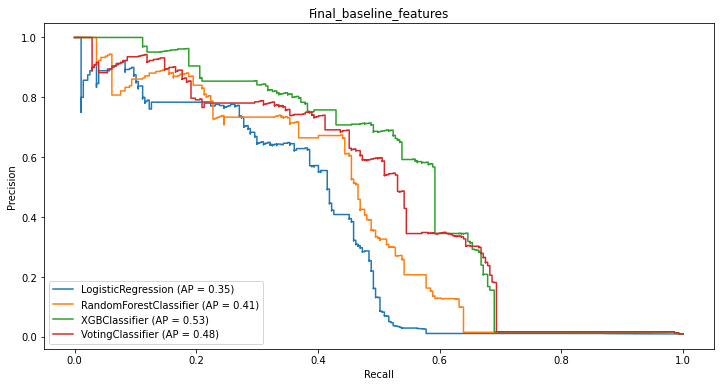

In [86]:
# Baseline features with class ratio - balanced
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_baseline_features')

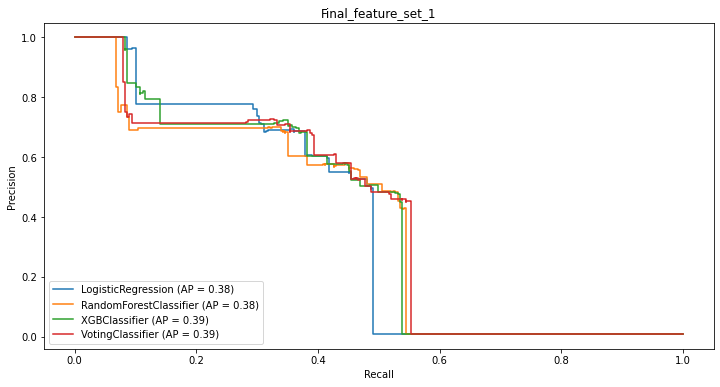

In [92]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Final_feature_set_1')

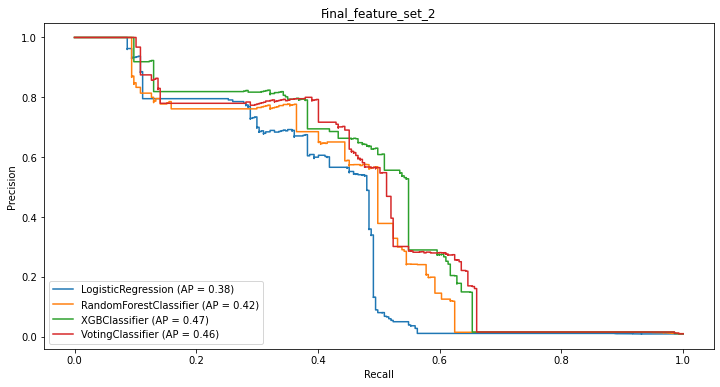

In [98]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Final_feature_set_2')

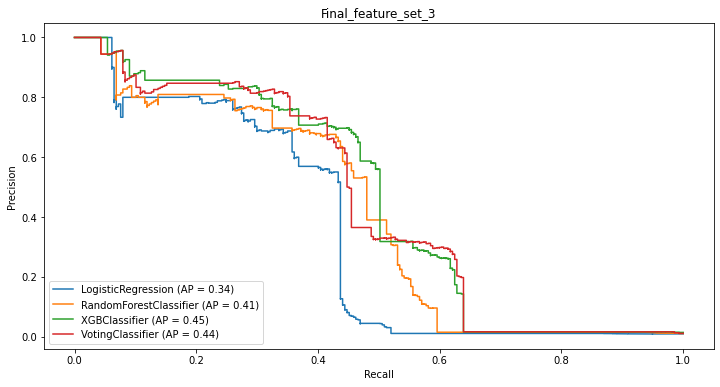

In [103]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Final_feature_set_3')

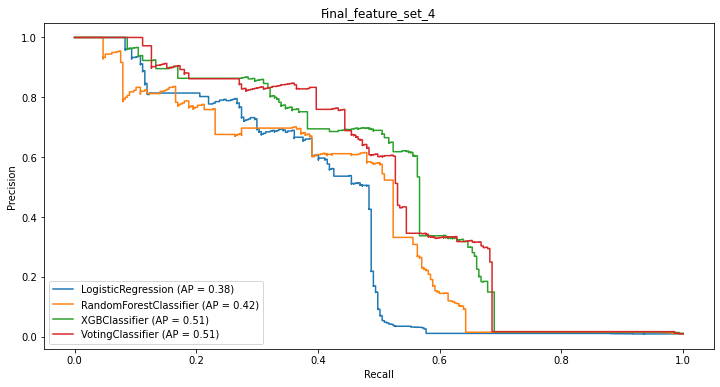

In [108]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Final_feature_set_4')

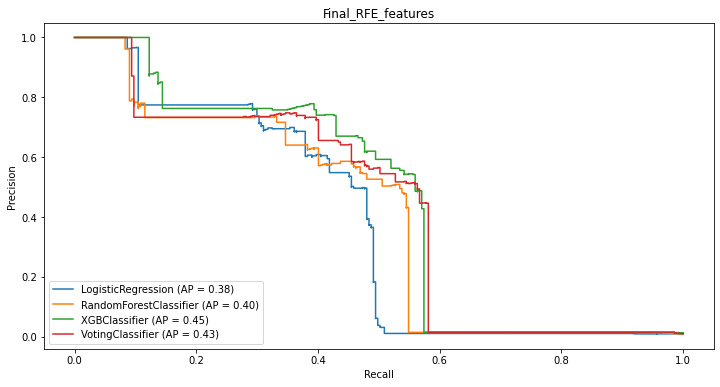

In [21]:
plot_pr_cuves(clf_list, x_test[rfe_feats], y_test,title = 'Final_RFE_features')

## E. Simple ANN with 4 FC layers
Worse performance than tree based methods, loss saturated at a point. Fairly deep network for simple structured data. Overfits very easily after just 3 epochs.

In [109]:
# standardised data to get 0 mean, 1 std
scale = StandardScaler()

featureset = feature_set_4

x_train = train[featureset]
y_train = train['Label']

# One-hot encoded labels
dummy_labels = np_utils.to_categorical(y_train)

x_test = test[featureset]
y_test = test['Label']

x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.fit_transform(x_test)
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [110]:
def base_model():
    model = Sequential()
    model.add(Dense(27, input_shape=(len(featureset),)))
    # Dropout regularization to prevent overfitting
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27, activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27,  activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(2, activation = 'sigmoid'))

# Learning parameters

    model.compile(optimizer = 'adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [111]:
model_ann = base_model()
model_ann.fit(x_train_scale, dummy_labels, batch_size = 32, epochs = 3, class_weight = {0:1, 1:class_weight})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
114706/114706 [==============================] - 17s 150us/step - loss: 1.1691 - accuracy: 0.9006
Epoch 2/3
114706/114706 [==============================] - 15s 132us/step - loss: 1.0234 - accuracy: 0.9794
Epoch 3/3
114706/114706 [==============================] - 15s 131us/step - loss: 1.0299 - accuracy: 0.9862


In [112]:
y_pred = model_ann.predict_classes(x_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.36      0.54      0.43       277

    accuracy                           0.99     29620
   macro avg       0.68      0.77      0.71     29620
weighted avg       0.99      0.99      0.99     29620



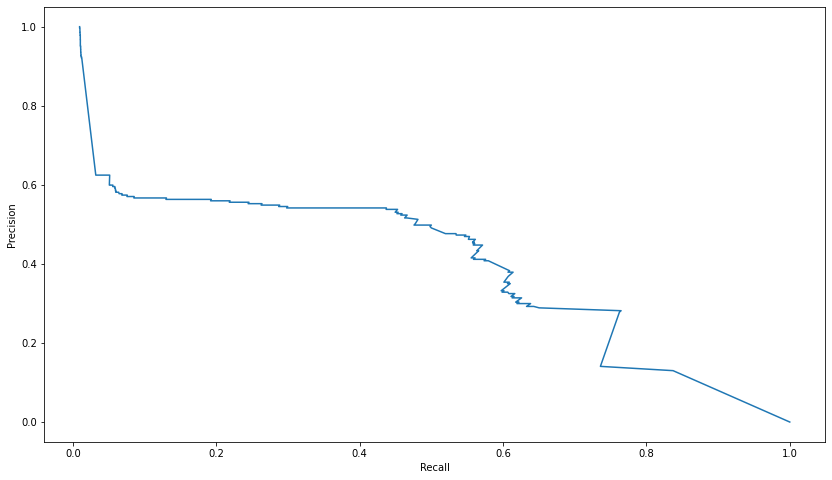

In [113]:
# Plotting precision-Recall on Test Set.
y_pred_proba = model_ann.predict_proba(x_test_scale)
pred_curve = precision_recall_curve(y_test, y_pred_proba[:,1])
plt.plot(pred_curve[0], pred_curve[1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## F. SMOTE - Synthetic Minority Oversampling Technique
Artificially generates minority sample points via a nearest neighbour type approach. New instances generated by synthesizing them inbetween features of existing minority samples. Artificially boost the number of minority samples to the around the same as the majority samples. <br>
Worse performance than class_weights = 'balanced'. Better than undersampling, requires tuning of the hypeparameter - ratio: of majority and minority class samples for binary classification. <br>
Important to only uses synthetic points for training, not for validation or test, that'll skew your results and does more harm than good.

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = .1)

x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [22]:
y_train.value_counts()

0    113630
1      1076
Name: Label, dtype: int64

In [23]:
y_train_res.value_counts()

0    113630
1     11363
Name: Label, dtype: int64

In [24]:
# Initialising Classifiers with gridsearch optimised parameters, log-reg wont converge with all features
# f-1 score on train dataset. Scores when optimising in excel sheet.

clf_log = LogisticRegression( max_iter = 300)
clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6)
xgb_clf = XGBClassifier(eta = .3, max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .5, eval_metric = 'aucpr')
# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train_res), y_train_res)
clf_rf.fit(np.array(x_train_res), y_train_res)
xgb_clf.fit(np.array(x_train_res), y_train_res, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train_res, clf_log.predict(np.array(x_train_res)))}')
print(f'Random Forest - {f1_score(y_train_res, clf_rf.predict(np.array(x_train_res)))}')
print(f'XGBoost - {f1_score(y_train_res, xgb_clf.predict(np.array(x_train_res)))}')

/home/desktop-anand/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0]	validation_0-aucpr:0.39663
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.41234
[2]	validation_0-aucpr:0.41719
[3]	validation_0-aucpr:0.44915
[4]	validation_0-aucpr:0.44232
[5]	validation_0-aucpr:0.45143
[6]	validation_0-aucpr:0.46015
[7]	validation_0-aucpr:0.46163
[8]	validation_0-aucpr:0.46445
[9]	validation_0-aucpr:0.47451
[10]	validation_0-aucpr:0.47348
[11]	validation_0-aucpr:0.45075
[12]	validation_0-aucpr:0.46745
[13]	validation_0-aucpr:0.46928
[14]	validation_0-aucpr:0.47480
[15]	validation_0-aucpr:0.48197
[16]	validation_0-aucpr:0.48458
[17]	validation_0-aucpr:0.48323
[18]	validation_0-aucpr:0.48975
[19]	validation_0-aucpr:0.49728
[20]	validation_0-aucpr:0.49725
[21]	validation_0-aucpr:0.50001
[22]	validation_0-aucpr:0.50135
[23]	validation_0-aucpr:0.50420
[24]	validation_0-aucpr:0.50574
[25]	validation_0-aucpr:0.50817
[26]	validation_0-aucpr:0.50827
[27]	validation_0-aucpr:0.50708
[28]	validation_0-aucpr:0.50740
[29]	validation_0

In [25]:
y_pred_log = clf_log.predict(np.array(x_test))
y_pred_rf = clf_rf.predict(np.array(x_test))
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('Logistic Regression\n', f1_score(y_test, y_pred_log))
print('RandomForestClassifier\n', f1_score(y_test, y_pred_rf))
print('XGBClassifier\n',f1_score(y_test, y_pred_xgb))

Logistic Regression
 0.4892703862660945
RandomForestClassifier
 0.48910411622276034
XGBClassifier
 0.5751391465677179


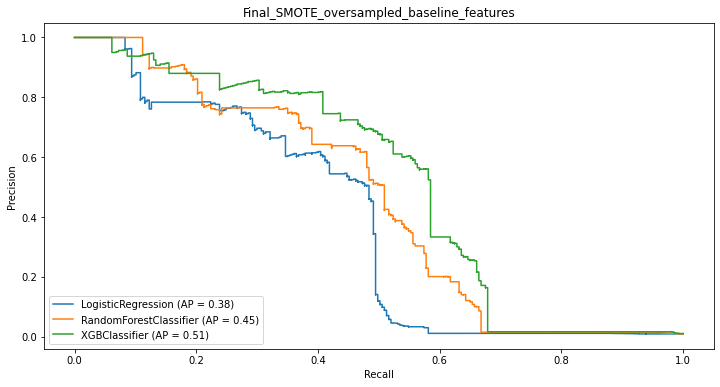

In [26]:
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_SMOTE_oversampled_baseline_features')

# G. Isolation Forest
Unsupervised approach where we build multiple trees with the goal of isolating the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from your data set. The trees are being split randomly. We assume that if one observation is similar to others in our dataset, it will take more random splits to perfectly isolate this observation, as opposed to isolating an outlier. For an outlier that has some feature values significantly different from the other observations, randomly finding the split isolating it should not be too hard. As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous.

In [27]:
# It is known that the contamination is 0.009381, not sure if its reasonable to assume that'll always be the case.
# Trying without auto
isforest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',
                max_features=1.0, bootstrap=False, n_jobs=-1,
                behaviour='deprecated', random_state=None, verbose=1, warm_start=False)

In [35]:
featureset = feature_set_1
isforest.fit(x_train[featureset])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


IsolationForest(n_jobs=-1, verbose=1)

In [36]:
res = isforest.predict(x_test[featureset])
res_score = isforest.score_samples(x_test[featureset])
np.unique(res, return_counts=True)

(array([-1,  1]), array([  451, 29169]))

In [37]:
iso_for = pd.DataFrame({'preds' : res,
                          'actual' : y_test,
                          'scores' : -res_score})
iso_for.preds.replace(to_replace=1, value = 0, inplace=True)
iso_for.preds.replace(to_replace=-1, value = 1, inplace=True)
iso_for.preds.value_counts()

0    29169
1      451
Name: preds, dtype: int64

In [38]:
print(classification_report(iso_for.actual, iso_for.preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.31      0.50      0.38       277

    accuracy                           0.98     29620
   macro avg       0.65      0.75      0.69     29620
weighted avg       0.99      0.98      0.99     29620



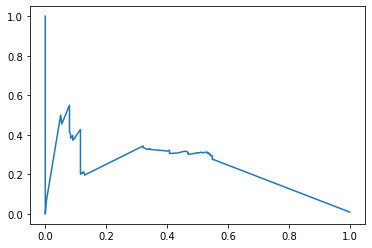

In [39]:
precision, recall, aucpr_score = precision_recall_curve(iso_for.actual, iso_for.scores)
plt.plot(recall, precision)

## 2. Time-Series Approach - Exploring overall Time-Series and by Account ID.
1. The data can be though of as 62 simultaneous time-series, for each feature,for each account. 
2. The time-series are different lengths, makes sense for different customers joining/leaving at different times. Is a problem, looking at a single account first and also how the label acts over all accounts over time.
3. Plot the number of positive labels for the time series, overlay with the number of unique accounts then. See if spike, seasonality etc. (Done)
4. Plot the time series for featuresets from above. (Done)

#### Overall Time-Series : Number of Accounts and Interventions over time
1. There doesn't appear to be any relationship between the growth in the number of accounts, and the number of interventions. One problem is that the cumulative sum includes duplicate accounts. Plotting the change in accounts seems to show a relationship between the two. Statistically significant, strong linear relationship according to pearsons correlation coefficient.
2. Bi-yearly seasonality looks to be present in the number of interventions required.

In [229]:
# Reloading, cannot index by account id, groupby isn't working as expected.
train = pd.read_csv('Train_Set.csv')
test = pd.read_csv('Test_Set.csv')

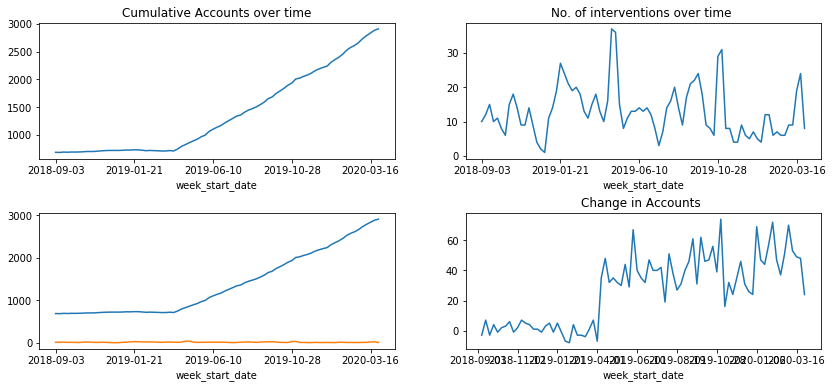

In [246]:
fig, ax = plt.subplots(2, 2, figsize = (14, 6))
plt.subplots_adjust(hspace = 0.4)
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[0,0])
ax[0,0].set_title('Cumulative Accounts over time')
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[0,1])
ax[0,1].set_title('No. of interventions over time ')
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[1,0])
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1,0])
change = (temp.groupby(['week_start_date'])['account_id'].count() - 
          temp.groupby(['week_start_date'])['account_id'].count().shift(1))
change.plot(kind = 'line', ax = ax[1,1])
ax[1,1].set_title('Change in Accounts ')
plt.show()

In [224]:
pearsonr(train.groupby(['week_start_date'])['account_id'].count()[1:].values, change.values[1:])

(0.7077372820234344, 1.0515141605376794e-13)

Comparing the trend and any spike in positive labels, and the sum of the values of the features, there doesn't seem to be much correlation except for what was seen in the correlation heatmap.

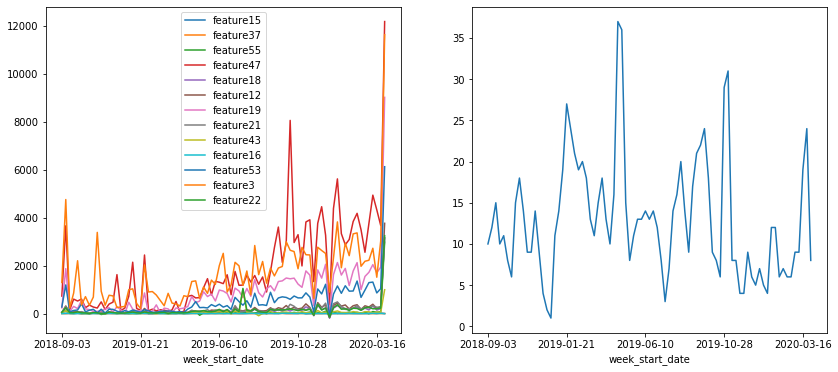

In [263]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

for item in feature_set_4:
    train.groupby(['week_start_date'])[item].sum().plot(legend = True, ax = ax[0])
    
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1])
plt.show()

#### Account Wise Time-Series

In [232]:
# Accounts with most sample points. 
train['account_id'].value_counts()

104959.0    280
105810.0    278
109056.0    278
100618.0    274
102171.0    272
           ... 
100796.0      1
187594.0      1
101642.0      1
239954.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

Difficult to pin-point any obvious relationship between a features value and the label just by looking at the data. 

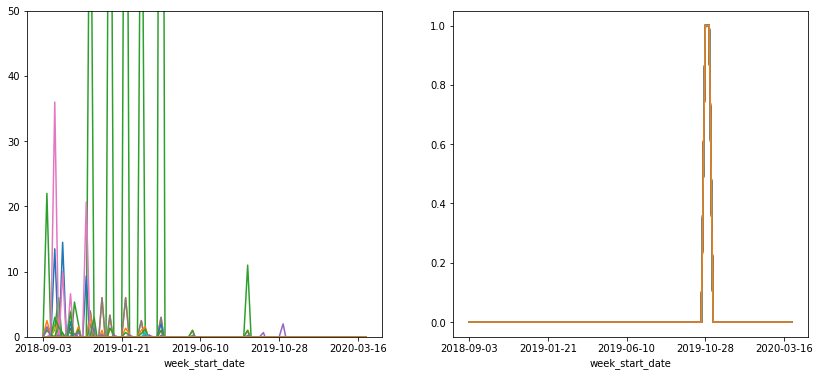

In [284]:
temp = train.loc[train['account_id'] == 104959.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].sum().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

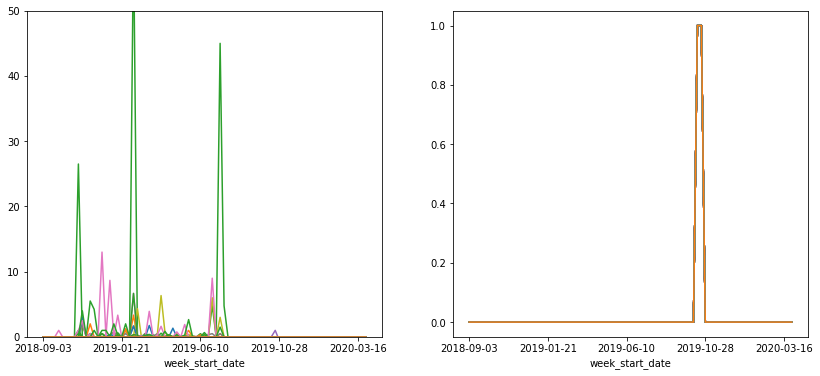

In [288]:
temp = train.loc[train['account_id'] == 105810.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

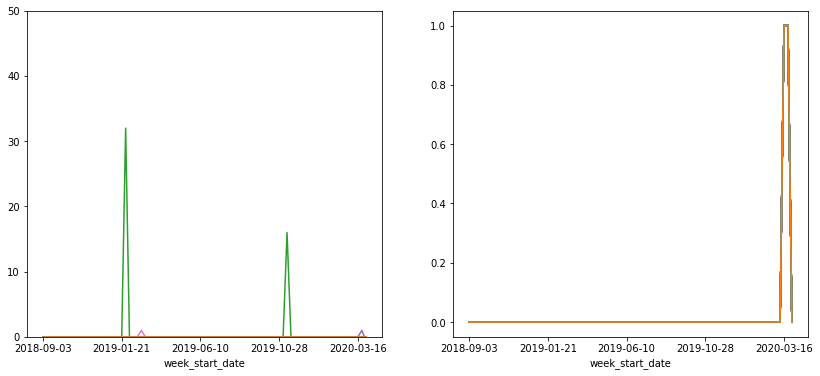

In [289]:
temp = train.loc[train['account_id'] == 109056.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))s
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()